In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D

2023-08-30 18:10:59.207941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 18:10:59.297008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 18:10:59.297995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 18:11:01.046147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 512
max_epochs = 20
filters = [32,32,16]

In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5
x_train_noisy = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

#print(x_test_noisy[1].dtype)

In [4]:
class Encoder(K.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2), padding='same')
                   
    def call(self, input_features):
        x = self.conv1(input_features)
        #print("Ex1", x.shape)
        x = self.pool(x)
        #print("Ex2", x.shape)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

In [5]:
class Decoder(K.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='valid')
        self.conv4 = Conv2D(1, 3, 1, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2, 2))
  
    def call(self, encoded):
        x = self.conv1(encoded)
        #print("dx1", x.shape)
        x = self.upsample(x)
        #print("dx2", x.shape)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        return self.conv4(x)

In [6]:
class Autoencoder(K.Model):
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)

    def call(self, input_features):
        #print(input_features.shape)
        encoded = self.encoder(input_features)
        #print(encoded.shape)
        reconstructed = self.decoder(encoded)
        #print(reconstructed.shape)
        return reconstructed

In [7]:
model = Autoencoder(filters)

model.compile(loss='binary_crossentropy', optimizer='adam')

loss = model.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=max_epochs,
                batch_size=batch_size)

2023-08-30 18:11:07.950319: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-30 18:11:08.096356: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20


2023-08-30 18:11:08.631384: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


118/118 [==============================] - 65s 529ms/step - loss: 0.3202 - val_loss: 0.2292
Epoch 2/20
118/118 [==============================] - 61s 520ms/step - loss: 0.2046 - val_loss: 0.1852
Epoch 3/20
118/118 [==============================] - 62s 525ms/step - loss: 0.1733 - val_loss: 0.1614
Epoch 4/20
118/118 [==============================] - 61s 521ms/step - loss: 0.1560 - val_loss: 0.1485
Epoch 5/20
118/118 [==============================] - 61s 521ms/step - loss: 0.1462 - val_loss: 0.1428
Epoch 6/20
118/118 [==============================] - 61s 518ms/step - loss: 0.1403 - val_loss: 0.1363
Epoch 7/20
118/118 [==============================] - 61s 514ms/step - loss: 0.1360 - val_loss: 0.1332
Epoch 8/20
118/118 [==============================] - 61s 518ms/step - loss: 0.1329 - val_loss: 0.1313
Epoch 9/20
118/118 [==============================] - 62s 529ms/step - loss: 0.1306 - val_loss: 0.1281
Epoch 10/20
118/118 [==============================] - 63s 534ms/step - loss: 0.1284

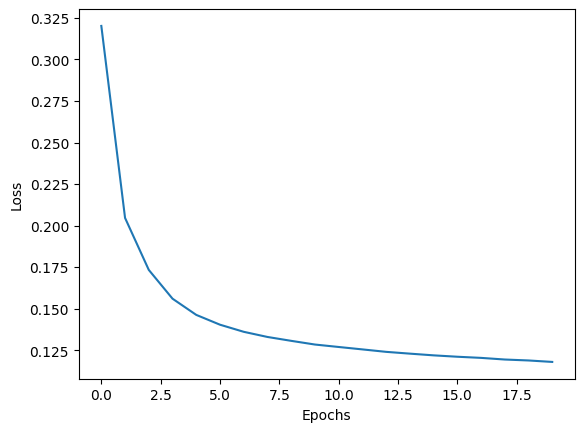

In [8]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

2023-08-30 18:31:47.575031: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1003520000 exceeds 10% of free system memory.
2023-08-30 18:31:48.328692: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1003520000 exceeds 10% of free system memory.
2023-08-30 18:31:49.334664: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1003520000 exceeds 10% of free system memory.


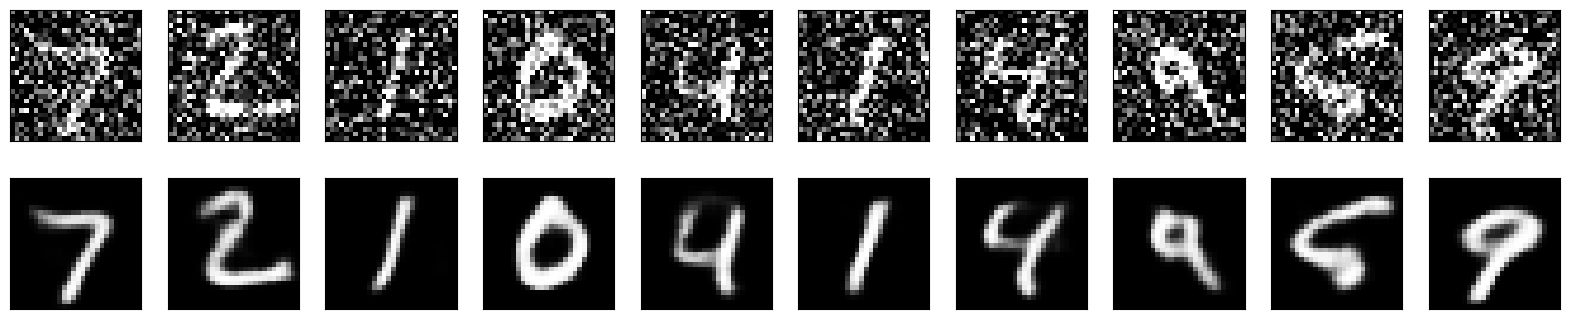

In [9]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(tf.reshape(model(x_test_noisy)[index], (28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

---